# Qubit decoherence simulation

### Author: Daniel Gonçalves Benvenutti - UNICAMP

28 March 2025

Qutip version: 5.1.1

This notebooks simulates the caracterization of a qubit with relaxation ($T_1$) and dephasing ($T_2$) colapse operators using the qutip quantum simulation library and the paralelism from qutip's library. It separates the simulations into time dependant and time independant for efficiency by using the final state as initial state of the next step for the procedure simulated.

It has the following simulations:
- Rabi oscillation,
-  Rabi map,
- $T_1$ decay,
- Ramsey oscillation for $T_2^*$,
- Ramsey map,
- $T_2^{echo}$






In [1]:
# to use in google colab
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 11.8 MB/s eta 0:00:00


In [1]:
import qutip as qtp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
USE_MP = True

# General parameters

Ref: [Naghiloo, Mahdi. "Introduction to experimental quantum measurement with superconducting qubits." arXiv preprint arXiv:1904.09291 (2019).](https://arxiv.org/pdf/1904.09291)

### Free evolution Hamiltonian
This is the hamiltonian used when the qubit is not affected by any external signal except the decoherence described by the collapse opperators.
$$H=-0.5\omega_q \sigma_z$$

### Time dependant Hamiltonian with drive in the rotating frame
When we want to affect the qubit we use the drive signal represented here by $E_d(t)$ which is typically a cosine wave with frequency close to the qubit resonance frequency $\omega_q$. This hamiltonian is time dependant because of  $E_d(t)$ and thus has a more time consuming simulation.

$$H=-0.5\omega_q \sigma_z-E_d(t) \sigma_x$$

### Collapse operators
These operators represent interactions with the external environment and are added in the Lidblad Master equation  that complements the Schrodinger equation with these external interactions. The one in the left is the relaxation and represents a loss in energy to the environment and the right one represents a disturbance in the phase of the system by an external agent. The relationship of the decay time constants is given by $\frac{1}{T_2}=\frac{1}{2T_1}+\frac{1}{T_\phi}$.
$$\sqrt{\frac{1}{T_1}}\sigma_-, \sqrt{\frac{1}{2T_\varphi}}\sigma_z$$

### Measurement operator
This is just the operator whose expectation value corresponds to the probabilty of measuring the excitation of the qubit at a given moment in it's evolution.
$$n=\sigma_-^\dagger\sigma_-=\sigma_+\sigma_-$$

## Numerical errors in the simulation
The numerical errors were in this simulation a bigger problem when considering the dephasing. The numerical errors worsen it making the $T_2^*$  and $T_2^{\textrm{echo}}$ obrtained smaller. Decreasing the error tolerances `atol` and `rtol` in the simulation options aleviated these errors as well as using the suggestions described below for the units used.

### Chosing the units of the parameters

 The units used should make the main simulation parameters approach ~1, so we should use gigahertz and nanoseconds instead of Hz and seconds if our qubit resonance frequency $\omega_q$ is of the order of gigahertz This will reduce numerical errors and make the simulation faster.

You can too normalize the units by $\omega_q$ (wq) for the same reason, this means dividing energies and frequencies by $\omega_q$  and multiplying the time by $\omega_q$ when in the simulation making it closer to 1.

The reason for that is that large floating numbers such as $10^9$ are harder to represent for a computer with precision and over a large simulations or calculations these errors will accumulate.




In [47]:
# parameters
wq=3*2*np.pi #qubit resonance frequency [GHz.rad]
Ed=0.01*2*np.pi #driving energy [GHz.rad]

pi_pulse=np.pi/Ed
print(f"pi pulse={pi_pulse:.2e}")

T1=20000 #relaxation time [ns]
T2=10000 #dephasing time [ns]

# (T2 must be T2<=2T1)
if T2>2*T1:
  raise Exception("T2 must be T2<=2T1")

# operators
sm=qtp.destroy(2)
sx=qtp.sigmax()
sz=qtp.sigmaz()
sy=qtp.sigmay()
n=sm.dag()*sm

# hamiltonian
def H(wq, Ed_t):
  # time independant hamiltonian (normalized by wq)
  if Ed_t==0:
    return -0.5*wq*sz/wq
  # time dependant hamiltonian
  # [time independant part, [operator,time dependant operator amplitude]]
  # [qubit, [drive]]
  return [-0.5*wq*sz/wq,[sx/wq,Ed_t]]
  #return [-0.5*wq*sz,[sx,Ed_t]]

# colapse operators normalized by wq
def c_ops(T1, T2):
  gamma_phi=1/T2-1/2/T1 #pure dephasing constant
  #return [np.sqrt(1/T1)*sm,np.sqrt(gamma_phi/2)*sz]
  return [np.sqrt(1/T1/wq)*sm,np.sqrt(gamma_phi/2/wq)*sz]

  #return [np.sqrt(1/T1)*sm,np.sqrt(2*gamma_phi)*n] #same thing for dephasing but in different terms



pi pulse=5.00e+01


# Rabi Oscillation
This is an oscillation of the qubit expectation value that occurs when we use the drive in the qubit. By using the correct period we can set the expectation value at a desired target such as an excited qubit ($\pi$ pulse) or a qubit in a superposition( $\pi/2$ pulse). We typically find this period by running this oscillation procedure.


In [48]:
# simulation
t=np.linspace(0,500,1000) #ns

def rabi(Det):
  # Detuned rabi oscillation with Det in [GHz]
  # initial state
  psi0=qtp.basis(2,0)

  # drive pulse
  def drive(t):
    wd=wq+Det*2*np.pi # drive angular freq
    return Ed*np.sin(wd/wd*t) #we normalize the frequency by wq

  res=qtp.mesolve(H(wq,drive),psi0,t*wq,c_ops(T1, T2),e_ops=[n])
  # returns the whole oscillation for this detuning
  return res.expect[0]

In [49]:

# runs simulation
res=rabi(0.0)

# rabi osc pi pulse
i=np.argmax(res)
print("pi pulse:", t[i])


pi pulse: 50.050050050050054


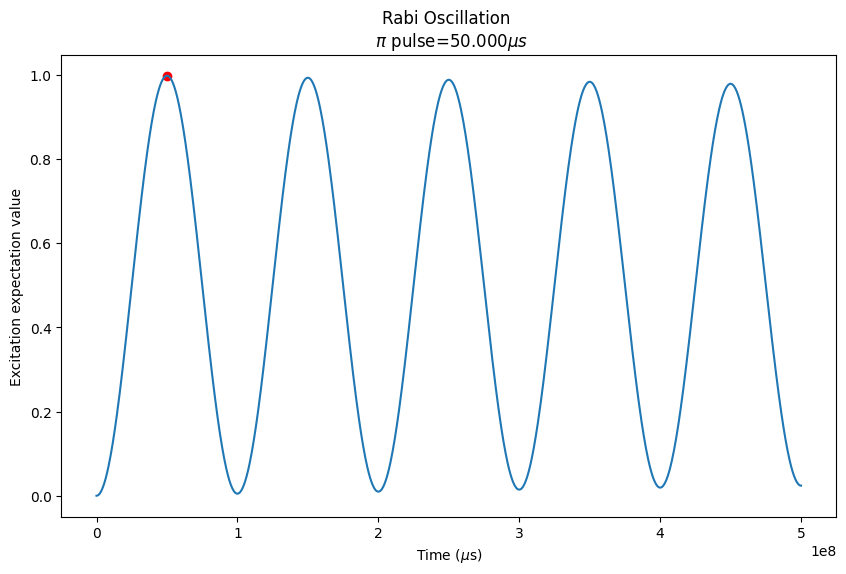

In [50]:
# prompt: plot res

fig, axes = plt.subplots(1, 1, figsize=(10,6))

axes.scatter(t[i]*1e6,res[i],color="red") #pi pulse peak
axes.plot(t*1e6, res)
axes.set_xlabel('Time ($\mu$s)')
axes.set_ylabel('Excitation expectation value')
axes.set_title(f'Rabi Oscillation \n $\pi$ pulse={pi_pulse:.3f}$\mu s$');


## Rabi map
The Rabi oscillation is typically done using the frequency of the drive at the resonance of the qubit. By inserting a small detuning we can observe a change in the behavior and period of the oscillation.

In [21]:
Det=np.linspace(-0.01,0.01,64) #GHz

# qutip's parallelism "map()" like function to evaluate all Detunings
if USE_MP:
    chevron=list(qtp.parallel.parallel_map(rabi,Det,progress_bar=True))
else:
    chevron=[rabi(d) for d in Det]
    


10.9%. Run time:   1.11s. Est. time left: 00:00:00:09
20.3%. Run time:   1.16s. Est. time left: 00:00:00:04
31.2%. Run time:   1.30s. Est. time left: 00:00:00:02
40.6%. Run time:   1.36s. Est. time left: 00:00:00:01
50.0%. Run time:   1.41s. Est. time left: 00:00:00:01
60.9%. Run time:   1.45s. Est. time left: 00:00:00:00
70.3%. Run time:   1.47s. Est. time left: 00:00:00:00
81.2%. Run time:   1.49s. Est. time left: 00:00:00:00
90.6%. Run time:   1.50s. Est. time left: 00:00:00:00
100.0%. Run time:   1.57s. Est. time left: 00:00:00:00
Total run time:   1.63s


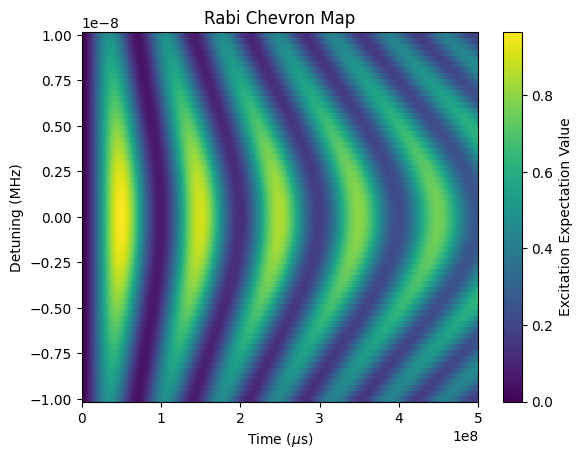

In [22]:
# prompt: plot the rabi chevron map with t as x axis and Det as y axis in pcolor


# Assuming 't' and 'Det' are defined from the previous code
T, Det = np.meshgrid(t, Det)

plt.pcolor(T * 1e6, Det * 1e-6, np.array(chevron))  # Plotting with correct units
plt.xlabel("Time ($\mu$s)")
plt.ylabel("Detuning (MHz)")
plt.title("Rabi Chevron Map")
plt.colorbar(label="Excitation Expectation Value")
plt.show()

# $T_1$ simulation
Here we do a $\pi$ pulse to let the qubit at the fully excited state and let the qubit evolve freely for different periods of time observing a exponential decay of the probability of measuring an excitation with a time constant $T_1$. This caracterises the relaxation kind of decoherence of the qubit.

In [21]:
# initial state
psi0=qtp.basis(2,0)


# times
# times for pi pulse simulation
t_pi_vec=np.linspace(0,pi_pulse,200) #ns
t=np.linspace(0,100000,10000) #ns
# you shouldn't start the free evolution at 0 because of the phase reference of the drive
# but since the drive in the T1 measurement is not used anymore after the pi pulse it's fine

# drive angular freq
wd=wq
# drive pulse
def drive(t):
  return Ed*np.sin(wd/wq*t) #we normalize the frequency by wq

# pi pulse simulation with time dependant hamiltonian
# it just simulates an excitation drive and returns the final state in the res_exc
res_exc=qtp.mesolve(H(wq,drive),psi0,t_pi_vec*wq,c_ops(T1,T2),e_ops=[],options={"store_final_state":True})

print(sm.dag() * res_exc.final_state * sm) # print the excitation expectation value after the pi pulse
print (psi0)
# T1 free evolution decay with time independant hamiltonian for efficiency
#res=qtp.mesolve(H(wq,0),res_exc.final_state,t*wq,c_ops(T1,T2),e_ops=[n])


Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.         0.        ]
 [0.         0.00246045]]
Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]]


C:\Users\jayamao\AppData\Local\Temp\ipykernel_11496\4204072120.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(exponential_func, t, res.expect[0], p0=[1, 20000, 0])  # Initial guess for parameters


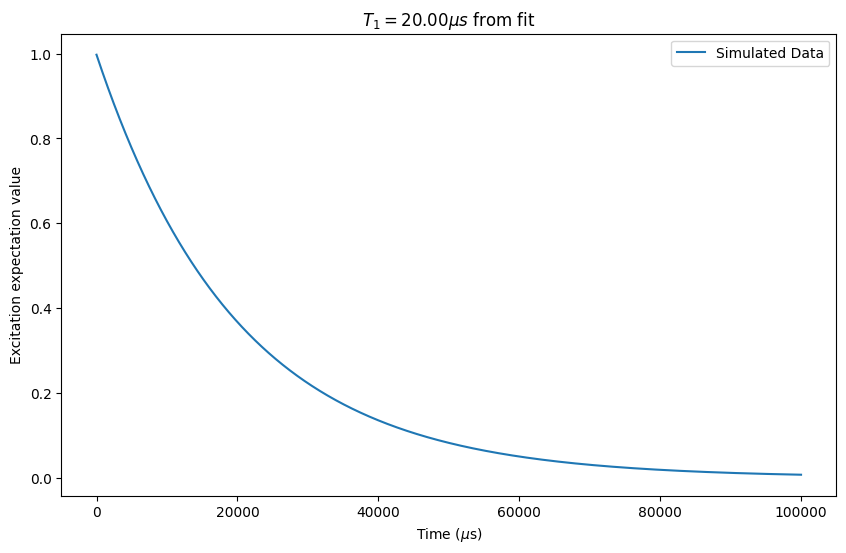

In [14]:
# prompt: prompt: plot res.expect[0] as scatter and fit it with an exponential

# Define the exponential function for fitting
def exponential_func(x, a, tau, c):
    return a * np.exp(- x/tau) + c

# Fit the exponential function to the data
params, covariance = curve_fit(exponential_func, t, res.expect[0], p0=[1, 20000, 0])  # Initial guess for parameters

# Extract fitted parameters
a, tau, c = params

# Generate fitted curve
fitted_curve = exponential_func(t, a, tau, c)


# Plotting
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.plot(t, res.expect[0], label='Simulated Data')
axes.set_xlabel('Time ($\mu$s)')
axes.set_ylabel('Excitation expectation value')
axes.set_title(f'$T_1= {tau/1e3:.2f}\mu s$ from fit')
axes.legend()
plt.show()


# $T_2$ Ramsey Simulation

This is one of the procedures to caracterize the $T_2$ or dephasing decoherence of the qubit. It works by doing a $\pi/2$ pulse that drives the qubit to a state of superposition, where the phase of the qubit has the most impact. Then waiting some time, the interrogation time $T$, and driving it with another $\pi/2$ pulse measuring the final state. Since at the superposition the qubit does a precession depending on the exact frequency of detuning on the drive from the qubit resonance. When we vary the interrogation time we observe an sinusoidal oscillation with the same frequency of the detuning. This oscillation has an exponetial decay with time constant $T_2^*$ related to the dephasing constant $T_2$. We can use this time constant with the $T_1$ value to caracterize the dephasing of the system.


In [15]:
def Ramsey(T, Det, Ed=Ed):
  # Ramsey simulation with interrogation time T in [ns] and detuning Det in [GHz]

  # The ramsey osccillation is more inefficient to simulate than Rabi
  # Because you need to evolve the whole simulation for each interrogation time

  # initial state
  psi0=qtp.basis(2,0)

  #drive pulse
  def drive(t):
    wd=wq+Det*2*np.pi
    return Ed*np.sin(wd/wq*t) #we normalize the frequency by wq

  # time values for the time dependant simulation during excitation
  # The time dependant part of the simulation is usually a bottleneck
  # less points doesn't necessarily means less time/work
  pi_pulse=np.pi/Ed
  step=2 # ns
  pi_vec=np.arange(0,pi_pulse/2+step,step) # ns

  # dictionary with simulation options
  # for T2 simulations we need higher numerical precision
  # so we set atol and rtol that limit the (estimated) error
  # per integration step to be smaller
  options={"store_final_state":True, "atol":1e-10,"rtol":1e-8}

  # Times for the free oscillation time independant simulation
  step=1 # ns
  t=np.arange(0,T+step,step) # ns

  # pi/2 pulse simulation with time dependant hamiltonian
  # it just simulates an excitation drive and returns the final state in the res_exc
  res=qtp.mesolve(H(wq,drive),psi0,pi_vec*wq,c_ops(T1,T2),e_ops=[],options=options)

  # shift to keep the phase consistent
  shift=pi_vec[-1]

  # for T=0 or smaller than step not to throw an error
  if T>=step:
    #Ramsey free evolution simulation
    res=qtp.mesolve(H(wq,0),res.final_state,wq*(t+shift),c_ops(T1,T2),e_ops=[],options=options)
    shift+=t[-1]

  # second ramsey pulse
  res=qtp.mesolve(H(wq,drive),res.final_state,wq*(pi_vec+shift),c_ops(T1,T2),e_ops=[],options=options)

  # return excitation expected value of the final state like a measurement
  return qtp.expect(n,res.final_state)



In [17]:
# interrogation times
T=np.linspace(0,4000,64) #ns

# wrapper to fix the detuning
def wrap_ramsey(T):
  return Ramsey(T,0.002) #Detuning in GHz

# qutip's parallelism "map()" like function to evaluate all points in T using Ramsey
#exp=list(qtp.parallel_map(wrap_ramsey,T,progress_bar=True))

exp = [wrap_ramsey(t) for t in T]



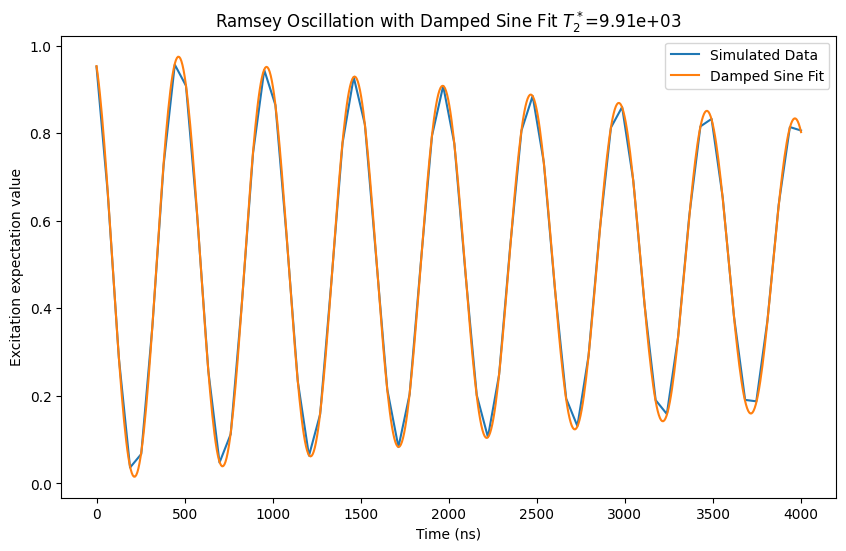

In [18]:
# prompt: plot exp and t as a ramsey oscillation with a damped sine fit


def damped_sine(t, amplitude, frequency, tau, phase, offset):
  return amplitude * np.exp( - t/tau) * np.sin(2 * np.pi * frequency * t + phase) + offset

params, covariance = curve_fit(damped_sine, T, exp, p0=[0.5, 0.002, 1000, 0, 0.5])

amplitude, frequency, decay_constant, phase, offset = params
t=np.linspace(T[0],T[-1],len(T)*10)
fitted_exp = damped_sine(t, amplitude, frequency, decay_constant, phase, offset)

fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(T, exp, label='Simulated Data')
axes.plot(t, fitted_exp, label='Damped Sine Fit')
axes.set_xlabel('Time (ns)')
axes.set_ylabel('Excitation expectation value')
axes.set_title(f'Ramsey Oscillation with Damped Sine Fit $T_2^*$={params[2]:.2e}')
axes.legend()
plt.show()

In [19]:
print(drive(1))

0.052871181281629126


## Ramsey map
With this map where we also vary and plot the detuning we can see the detuning=oscillation frequency relationship mentioned above.

In [5]:
# interrogation times and detunings
T=np.linspace(0,4000,128) # ns
Det=np.linspace(-0.002,0.002,72) # GHz

# generates pairs for each coordinate and puts them in a 1D list
T,Det=np.meshgrid(T,Det)
pairs=np.array([T.flatten(),Det.flatten()]).T

# wrapper to apply the pairs to the function input
def wrapper_ramsey(pair):
  return Ramsey(pair[0],pair[1])

# executes the simulations with parallelism
exp=list(qtp.parallel_map(wrapper_ramsey, pairs,progress_bar=True))

# reshapes the list of results into a matrix
rmap=np.array(exp).reshape(T.shape)

10.0%. Run time: 2155.74s. Est. time left: 00:05:23:12
20.0%. Run time: 4314.41s. Est. time left: 00:04:47:28
30.0%. Run time: 6501.04s. Est. time left: 00:04:12:47
40.0%. Run time: 8723.55s. Est. time left: 00:03:38:01
50.0%. Run time: 10948.28s. Est. time left: 00:03:02:28
60.0%. Run time: 13086.59s. Est. time left: 00:02:25:22
70.0%. Run time: 15253.66s. Est. time left: 00:01:48:54
80.0%. Run time: 17437.85s. Est. time left: 00:01:12:38
90.0%. Run time: 19648.20s. Est. time left: 00:00:36:21
100.0%. Run time: 21874.07s. Est. time left: 00:00:00:00
Total run time: 21874.10s


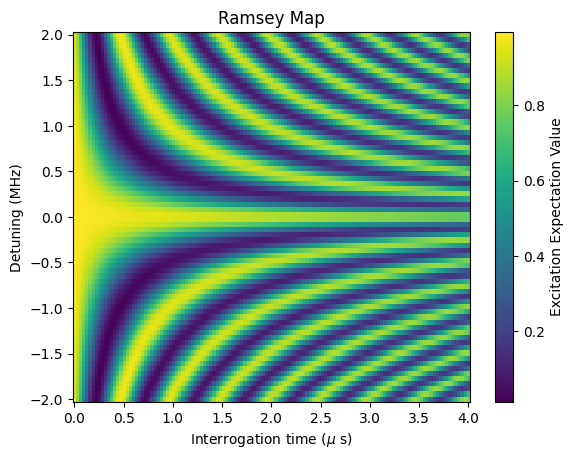

In [6]:
# prompt: Plot exp pcolor map with T and Det as axis


# Assuming T and Det and exp are defined from the previous code block
plt.pcolormesh(T/1000, Det*1000, rmap)
plt.xlabel("Interrogation time ($\mu$ s)")
plt.ylabel("Detuning (MHz)")
plt.title("Ramsey Map")
plt.colorbar(label="Excitation Expectation Value")
plt.show()

# $T_2^{echo}$ simulation
This is another procedure to caracterize the dephasing of the system like the Ramsey oscillation. It works similiarly to it but instead of having only two pulses and a detuning on the drive it has a $\pi$ pulse in the middle of the interrogation time. This pi pulse cancels out the precession by making it go back in the other direction after the $\pi$ pulse and makes us see only the result of the dephasing. The time constant of the exponential obtained on the varying times of the sum of two interrogation intervals is $T_2^{\textrm{echo}}$ and is equal or greater to $T_2$. Here it's smaller because the numerical errors in simulating the qubit worsen our dephasing.

In [ ]:
def echo(T, Det):
  # Ramsey simulation with interrogation time T in [s] and detuning Det in [Hz]

  # initial state
  psi0=qtp.basis(2,0)

  # time values for the time dependant simulation during excitation
  # The time dependant part of the simulation is usually a bottleneck
  pi_pulse=np.pi/Ed # ns
  # step=2*np.pi/wq/2 #step for time dependant a half the qubit energy period
  #pi2_vec=np.arange(0,pi_pulse/2+step,step)
  #pi_vec=np.arange(0,pi_pulse+step,step)

  pi2_vec=np.linspace(0,pi_pulse/2,64) # ns
  pi_vec=np.linspace(0,pi_pulse,128) # ns


  # drive pulse
  def drive(t):
    wd=(wq+Det*2*np.pi)
    return Ed*np.sin(wd/wq*t) #we normalize the frequency by wq

  # Times for the free oscillation time independant simulation
  #step=2*np.pi/wq/2 #a half the qubit energy period
  step=2 # ns
  t=np.arange(0,T+step,step) # ns

   # dictionary with simulation options
  # for T2 simulations we need higher numerical precision
  # so we set atol and rtol that limit the (estimated) error
  # per integration step to be smaller
  options={"store_final_state":True, "atol":1e-9,"rtol":1e-7}

  # pi/2 pulse simulation with time dependant hamiltonian
  # it just simulates an excitation drive and returns the final state in the res_exc
  res=qtp.mesolve(H(wq,drive),psi0,wq*pi2_vec,c_ops(T1,T2),e_ops=[],options=options)

  # shift to keep the phase consistent
  shift=pi2_vec[-1] # ns

  # for T=0 or smaller than step not to throw an error
  if T>=step:
    #t2echo first free evolution simulation
    res=qtp.mesolve(H(wq,0),res.final_state,wq*(t+shift),c_ops(T1,T2),e_ops=[],options=options)
    shift+=t[-1]


  # pi pulse simulation with time dependant hamiltonian
  res=qtp.mesolve(H(wq,drive),res.final_state,wq*(pi_vec+shift),c_ops(T1,T2),e_ops=[],options=options)
  shift+=pi_vec[-1]


  if T>=step:
    # t2echo second free evolution simulation
    res=qtp.mesolve(H(wq,0),res.final_state,wq*(t+shift),c_ops(T1,T2),e_ops=[],options=options)
    shift+=t[-1]

  # second pi/2 pulse
  res=qtp.mesolve(H(wq,drive),res.final_state,wq*(pi2_vec+shift),c_ops(T1,T2),e_ops=[],options=options)

  # return excitation expected value of the final state like a measurement
  return qtp.expect(n,res.final_state)



In [ ]:
# the size of the two interrogation times in between pulses
T=np.linspace(0,16000,16) # ns

# wrapper to fix the detuning
def wrap_echo(T):
  return echo(T,0)

# qutip's parallelism "map()" like function to evaluate all points in T using Ramsey
exp=list(qtp.parallel_map(wrap_echo,T,progress_bar=True))


12.5%. Run time:   2.63s. Est. time left: 00:00:00:18
25.0%. Run time:  10.81s. Est. time left: 00:00:00:32
31.2%. Run time:  15.73s. Est. time left: 00:00:00:34
43.8%. Run time:  30.58s. Est. time left: 00:00:00:39
50.0%. Run time:  40.91s. Est. time left: 00:00:00:40
62.5%. Run time:  63.89s. Est. time left: 00:00:00:38
75.0%. Run time:  92.06s. Est. time left: 00:00:00:30
81.2%. Run time: 107.96s. Est. time left: 00:00:00:24
93.8%. Run time: 141.60s. Est. time left: 00:00:00:09
100.0%. Run time: 152.82s. Est. time left: 00:00:00:00
Total run time: 152.85s


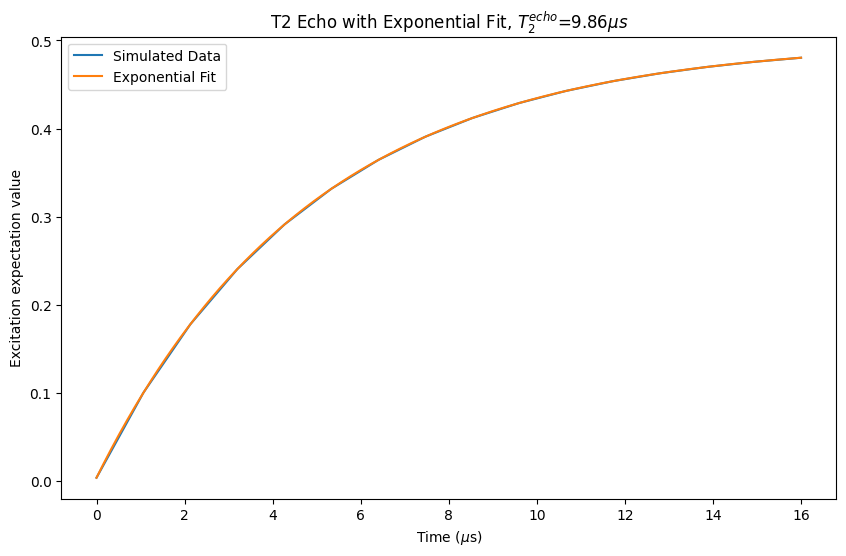

In [ ]:
# prompt: plot the t2 echo exp with T and an exponential upside down non oscillating fit with the time constant in the title of the graph

# Assuming T and exp are defined from the previous code block (T2 echo simulation)

def exponential_decay(t, amplitude, decay_constant, offset):
    return amplitude * np.exp(-t / decay_constant) + offset

params, covariance = curve_fit(exponential_decay, T, exp, p0=[-1, 1100, 0.5])

amplitude, decay_constant, offset = params
t_fit = np.linspace(T[0], T[-1], 1000)
fitted_exp = exponential_decay(t_fit, amplitude, decay_constant, offset)


fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.plot(T/1000, exp, label='Simulated Data')
axes.plot(t_fit/1000, fitted_exp, label='Exponential Fit')
axes.set_xlabel('Time ($\mu $s)')
axes.set_ylabel('Excitation expectation value')
axes.set_title(f'T2 Echo with Exponential Fit, $T_2^{{echo}}$={2*decay_constant/1000:.2f}$\mu s$')
axes.legend()
plt.show()